In [1]:
import numpy as np 
import numpy.typing as npt 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import re
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

from scipy.spatial import distance
from scipy.stats import mode
from scipy.interpolate import interp1d

from dollarpy import Recognizer, Template, Point

from math import sqrt, floor
from typing import TextIO

In [2]:
USER_IDS = range(0, 10)

### Load datasets

In [4]:
def load_datasets(domain: str):
	dir_path = f"datasets/{domain}"

	start = ((int(domain.split("0")[1]) - 1) * 1000) + 1
	stop = start + 1000

	X = []
	Y = []

	# matrix (number_drawn, user_id)
	# at each cell we have a list of multiple try of a specific number drawing (number_drawn)
	# drawn by a specific user (user_id), each try contains a list of data points (x, y, z)
	hand_gesture_data_matrix = np.zeros((10, 10), dtype=object)
	for i in range(0, 10):
		for j in range(0, 10):
			hand_gesture_data_matrix[i, j] = []

	for filename in tqdm(range(start, stop)):
		file_path = f"{dir_path}/{filename}.txt"
		with open(file=file_path, mode="r") as f:
			# get the target, user_id 
			# and a list of positions vectors \in \R^3: <x, y, z>
			# that represents the drawing
			number_drawn, user_id, gesture_datas = load_gesture_data(file=f)

			X.append(gesture_datas)
			Y.append(number_drawn)

			hand_gesture_data_matrix[number_drawn - 1, user_id - 1].append(gesture_datas)

	return np.asarray(X), np.asarray(Y), hand_gesture_data_matrix

def load_gesture_data(file: TextIO):
	"""Load a hand gesture data file structured in the following way:
	-----
	Domain id = <domain-id>
	Class id = <class-id>
	User id = <user-id>

	"<x>,<y>,<z>,<t>"
	...
	-----

	Parameters
	----------
	file : TextIOWrapper
		Hand gesture data file

	Returns
	-------
	int
		Number drawn
	int 
		User id
	npt.NDArray, shape (n_timepoints, vec_dimension)
		Time series of hand gesture data points
	"""
	lines = file.readlines()
	
	number_drawn = lines[1].strip()
	match_number = re.search("=", number_drawn)
	number_drawn = int(match_number.string[match_number.end():].strip()) - 1

	user_id = lines[2].strip()
	match_user = re.search("=", user_id)
	user_id = int(match_user.string[match_user.end():].strip())

	gesture_datas = []

	for row in range(5, len(lines)):
		gesture_data = lines[row].split(",")
		# we only keep <x, y, z> coordinates
		gesture_data = np.asarray([float(data.strip()) for data in gesture_data[0:-1]])
		gesture_datas.append(gesture_data)
	
	return number_drawn, user_id, gesture_datas

X1, y1, hand_gesture_data_matrix1 = load_datasets(domain="Domain01")
X3, y3, hand_gesture_data_matrix3 = load_datasets(domain="Domain03")

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1851/40885229.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(X), np.asarray(Y), hand_gesture_data_matrix


  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
def vector_quantize(X: npt.NDArray, ts_length: float = 0.8) -> npt.NDArray:
	"""Preproces the dataset by performing a vector quantization of the signals. The idea is to reduce the length of the time series by ... % in order to reduce the computation time of the algorithms.

	Parameters
	----------
	X : npt.NDArray, shape (n_samples, n_timepoints, vec_dimensions)
		Dataset of the time series data points. Time series can vary in length (n_timepoints vary among samples).
	ts_length: float, in the range ]0,1]
		The percentage of time series to keep.

	Returns
	-------
	npt.NDArray, shape (n_samples, n_clusters, vec_dimensions)
		Dataset of the reduced length time series datapoints.
	"""
	if ts_length <= 0 or ts_length > 1:
		raise ValueError("ts_length should be a number in the range ]0,1]")

	X_compressed = []
	for sketch_data in tqdm(X):
		# vector quantization of the signal
		n_clusters = floor(len(sketch_data) * ts_length)
		kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
		kmeans.fit(sketch_data)
		X_compressed.append(kmeans.cluster_centers_)
	
	return np.array(X_compressed)

#X1_compressed = vector_quantize(X1, ts_length=0.5)

In [6]:
def resample_ts(ts: npt.NDArray, N: int = 64) -> npt.NDArray:
	"""Resample a time series of m data points into a time series of n_points data points by interpolation.

	Parameters
	----------
	ts : npt.NDArray, shape (n_timepoints, vec_dimension)
		the original time series
	N : int, optional
		the number of points to resample, by default 64

	Returns
	-------
	npt.NDArray, shape (N_timepoints, vec_dimension)
		the resampled time series
	"""
	ts = np.array(ts)
	
	n, p = ts.shape
	resampled_ts = np.zeros((N, p))

	t_old = np.arange(0, n, 1)
	t_new = np.linspace(0, n - 1, N)

	for dim in range(0, p):
		x_old = ts[:, dim]
		f = interp1d(t_old, ts[:, dim], axis=0)
		resampled_ts[:, dim] = f(t_new)
	
	return resampled_ts

def resample_dataset(X: npt.NDArray, N: int = 64):
	n_samples = len(X)
	resampled_X = np.zeros((n_samples, N, 3))

	for i in range(0, n_samples):
		# resample the time series to N = 64 data points
		# http://faculty.washington.edu/wobbrock/pubs/uist-07.01.pdf 
		ts = X[i]
		resampled_ts = resample_ts(ts, N = N)
		resampled_X[i] = resampled_ts
	
	#plot_sketch(resampled_X)
	return resampled_X

def standardize_dataset(X: npt.NDArray):
	n_samples = len(X)
	standardized_X = []

	scaler = StandardScaler()

	for i in range(0, n_samples):
		ts = X[i]
		scaled_ts = scaler.fit_transform(ts)
		standardized_X[i] = scaled_ts
	
	return standardized_X

### Cross-validation

In [37]:
def split_dataset(X, Y, slices):
	X_train = np.delete(X, slices, axis=0)
	y_train = np.delete(Y, slices, axis=0)

	X_test = X[slices]
	y_test = Y[slices]

	return X_train, X_test, y_train, y_test

def user_independent_cross_validation(estimator, X, y):
	y_preds = []
	y_tests = []
	accuracies = []

	for user_id in USER_IDS:
		slices = range(user_id * 100, 100 + (user_id * 100))
		X_train, X_test, y_train, y_test = split_dataset(X, y, slices)

		estimator.fit(X_train, y_train)
		y_pred = estimator.predict(X_test)

		accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
		accuracies.append(accuracy)

		y_tests.append(y_test)
		y_preds.append(y_pred)

	accuracy_mean = np.mean(accuracies)
	accuracy_std = np.std(accuracies)
	
	return accuracy_mean, accuracy_std, y_preds, y_tests

def user_dependent_cross_validation(estimator, X, y):
	n_samples = len(X)

	y_preds = []
	y_tests = []
	accuracies = []

	for user_id in USER_IDS:
		slices = np.arange(user_id, n_samples + user_id, 10)
		X_train, X_test, y_train, y_test = split_dataset(X, y, slices)


		estimator.fit(X_train, y_train)
		y_pred = estimator.predict(X_test)

		accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
		accuracies.append(accuracy)

		y_tests.append(y_test)
		y_preds.append(y_pred)

	accuracy_mean = np.mean(accuracies)
	accuracy_std = np.std(accuracies)
	
	return accuracy_mean, accuracy_std, y_preds, y_tests

def test_algo(estimator, X, y):
	X_train, X_test, y_train, y_test = split_dataset(X, y, user_id=0)

	estimator.fit(X_train, y_train)
	y_pred = estimator.predict(X_test)

	accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

	return accuracy, y_pred, y_test

In [8]:
import matplotlib.pyplot as plt

def plot_sketch(X: npt.NDArray):
	data = np.array(X[0])

	fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
	ax.scatter(data[:,0], data[:,1], data[:,2])

### Preprocessing

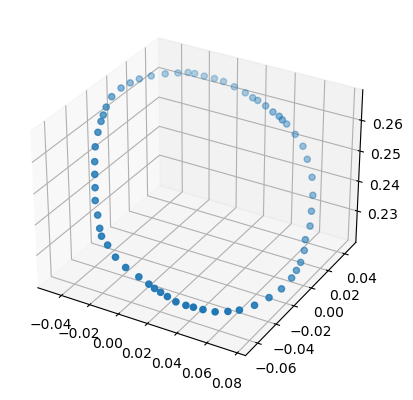

In [104]:
plot_sketch(X1_compressed)

### Dynamic Time Warping

In [9]:
# multivariate dtw distance computed as independent dtw
# compute the sum of distance of multiple univariate time series
# it can therefore benefits from optimization of univariate time series like LB_Keogh
# https://www.sciencedirect.com/science/article/pii/S0020025522013731#b0155 
def cumulative_distance(vec_a: npt.NDArray, vec_b: npt.NDArray):
	n = len(vec_a)
	m = len(vec_b)

	if n != m:
		raise ValueError("vec_a and vec_b are expected to have the same dimension.")
	
	distance = 0.0
	for i in range(0, n):
		# square of the euclidean distance
		distance += (vec_a[i] - vec_b[i]) ** 2

	return distance

# https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd
def dtw_distance(ts_a: npt.NDArray, ts_b: npt.NDArray, window: int = 3) -> float:
	"""Compute the DTW distance for two time series

	Parameters
	----------
	ts_a : npt.NDArray, shape (n_timepoints, vec_dimension)
		Time series of hand gesture data points
	ts_b : npt.NDArray, shape (m_timepoints, vec_dimension)
		Time series of hand gesture data points
	window : int, optional
		Window size, by default 3

	Returns
	-------
	float
		_description_
	"""

	n = len(ts_a)
	m = len(ts_b)

	DTW_matrix = np.full((n+1, m+1), fill_value=np.inf)

	# initial conditions
	DTW_matrix[0, 0] = 0.0

	for i in range(0, n):
		DTW_matrix[i, 0] = np.inf
	
	for j in range(0, m):
		DTW_matrix[0, j] = np.inf

	# window optimization
	window = max(window, abs(n - m))

	for i in range(0, n+1):
		for j in range(max(0, i - window), min(m, i + window) + 1):
			DTW_matrix[i, j] = 0.0

	# fill the matrix
	for i in range(1, n+1):
		for j in range(max(1, i - window), min(m, i + window) + 1):
			# manhattan distance
			cost = cumulative_distance(ts_a[i-1], ts_b[j-i])
			#cost = distance.sqeuclidean(ts_a[i-1], ts_b[j-1])
			optimal_warping_path = min(
				DTW_matrix[i-1, j], # insertion
				DTW_matrix[i, j-1], # deletion
				DTW_matrix[i-1, j-1] # match
			)

			DTW_matrix[i, j] = cost + optimal_warping_path
	
	return sqrt(DTW_matrix[n, m])

In [10]:
# CAVEAT: ONLY WORKS FOR MONODIMENSIONAL TIME SERIES...
def lb_keogh(ts_query: npt.NDArray, ts_candidate: npt.NDArray, window: int) -> float:
	"""Implement LB Keogh algorithm which is a fast lowerbounding method for constrained DTW distance

	Parameters
	----------
	ts_query : npt.NDArray, shape (n_timepoints,)
		Query time series to compare with the envelope of the candidate time series.
	ts_candidate : npt.NDArray, shape (m_timepoints,)
		Candidate time series, used to compute the envelope.
	window : int
		Windows size to use for the envelope generation

	Returns
	-------
	float
		Distance between the query time series and the envelope of the candidate time series
	"""
	n = min(len(ts_query), len(ts_candidate))
	lb_tot = 0

	for i in range(0, n):
		start = (i - window if i - window >= 0 else 0)
		stop = (i + window if i + window <= n - 1 else n - 1)

		lower_bound = min(ts_candidate[start:stop + 1])
		upper_bound = min(ts_candidate[start:stop + 1])

		if ts_query[i] > upper_bound[j]:
			lb_tot += (ts_query[i] - upper_bound) ** 2
		elif ts_query[i] < lower_bound[j]:
			lb_tot += (lower_bound - ts_query[i]) ** 2
			
	return sqrt(lb_tot)

In [11]:
from collections import defaultdict

def coarsening(ts):
	def averaging(ts, i):
		return (ts[i] + ts[i + 1]) / 2

	n = len(ts)
	averaged_ts = [averaging(ts, i) for i in range(0, n - (n % 2), 2)]
	return np.asarray(averaged_ts)

def expand_searching_window(warping_path, n, m, radius):
	warping_path_set = set(warping_path)

	for (i, j) in warping_path:
		for move_i in range(-radius, radius + 1):
			for move_j in range(-radius, radius + 1):
				neighbor_i = i + move_i
				neighbor_j = j + move_j
				if (neighbor_i >= 0 and neighbor_j >= 0):
					warping_path_set.add((neighbor_i, neighbor_j))
	
	window = set()
	
	for (i, j) in warping_path_set:
		for (a, b) in ((i * 2, j * 2), (i * 2, (j * 2) + 1), ((i * 2) + 1, j * 2), ((i * 2) + 1, (j * 2) + 1)):
			window.add((a, b))

	#print(window)

	searching_window = []
	start_j = 0

	for i in range(0, n):
		new_start_j = None
		for j in range(start_j, m):
			if (i, j) in window:
				searching_window.append((i, j))
				if new_start_j is None:
					new_start_j = j
			elif new_start_j is not None:
				break
		
		start_j = new_start_j

	#print(searching_window)
	return searching_window

def dtw(ts_a, ts_b, dist_function, window):
	n = len(ts_a)
	m = len(ts_b)

	#print(window)

	if window is None:
		window = [(i, j) for i in range(0, n) for j in range(0, m)]

	# shift (i, j) cell to (i + 1, j + 1)
	window = [(i + 1, j + 1) for i, j in window]

	cost_matrix = defaultdict(lambda: (float("inf"),))

	#print(window)

	# initial conditions
	cost_matrix[0, 0] = (0, (0, 0))

	# search for the optimal warping path
	for (i, j) in window:
		#print(i, j)
		#print(ts_a[i-1], ts_b[j-1])
		cost = dist_function(ts_a[i-1], ts_b[j-1])
		accumulated_cost_and_cell = min(
			(cost + cost_matrix[i-1, j][0], (i-1, j)), # insertion
			(cost + cost_matrix[i, j-1][0], (i, j-1)), # deletion
			(cost + cost_matrix[i-1, j-1][0], (i-1, j-1)), # match
			key = lambda x: x[0]
		)

		cost_matrix[i, j] = accumulated_cost_and_cell

	# reconstruct the path
	path = []
	i, j = n, m

	while not (i == 0 and j == 0):
		path.append((i - 1, j - 1))
		i, j = cost_matrix[i, j][1]
	path.reverse()

	return cost_matrix[n, m][0], path

def fast_dtw(ts_a, ts_b, dist_function, radius = 1):
	n = len(ts_a)
	m = len(ts_b)

	# min size of the coarsest resolution
	min_ts_size = radius + 2

	# base case: for really small time series,
	# run the full dtw algorithm
	if n <= min_ts_size or m <= min_ts_size:
		return dtw(ts_a, ts_b, dist_function, window=None)

	# coarsening
	ts_a_shrunk = coarsening(ts_a)
	ts_b_shrunk = coarsening(ts_b)

	# recursively compute a lower resolution path
	dist, low_res_path = fast_dtw(ts_a_shrunk, ts_b_shrunk, dist_function, radius)

	# compute a searching window
	searching_window = expand_searching_window(low_res_path, n, m, radius)

	return dtw(ts_a, ts_b, dist_function, searching_window)

In [12]:
# https://nbviewer.org/github/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb

# http://alexminnaar.com/2014/04/16/Time-Series-Classification-and-Clustering-with-Python.html

# https://www.sciencedirect.com/science/article/pii/S0031320317304387#bib0037

class KNN:
	def __init__(self, n_neighbors = 1, radius = 1, distance_fun = fast_dtw):
		self.n_neigbors = n_neighbors
		self.distance_fun = distance_fun
		self.radius = radius

		self.X = None 
		self.y = None
	
	def fit(self, X: npt.NDArray, y: npt.NDArray):
		"""Fit the model using X as training data and y as target

		Parameters
		----------
		X : npt.NDArray, shape (n_samples, n_timepoints, vec_dimension)
			Training data
		y : npt.NDArray, shape (n_samples,)
			Target data
		"""
		self.X = X
		self.y = y

	def distance_matrix(self, X_train: npt.NDArray, X_test: npt.NDArray):
		n = len(X_test)
		m = len(X_train)
		distance_matrix = np.zeros((n, m))

		for i in tqdm(range(0, n)):
			#min_dist = np.inf
			for j in range(0, m):
				#if lb_keogh(X_train[j], X_test[i], window=self.window) < min_dist:
				# compare each time series in the testing set 
				# with every other one in the training set
				#dist = self.distance_fun(X_test[i], X_train[j], window=self.window)
				dist, warping_path = fast_dtw(X_test[i], X_train[j], cumulative_distance, radius=self.radius)

				# keep track of the dtw distance between time series i and j
				distance_matrix[i, j] = dist
					#if dist < min_dist:
						#min_dist = dist
		
		return distance_matrix

	def predict(self, X: npt.NDArray) -> npt.NDArray:
		"""Predict the target values (here: class label) for the given testing dataset

		Parameters
		----------
		X : npt.NDArray, shape (n_samples, n_timepoints, vec_dimension)
			Testing data

		Returns
		-------
		npt.NDArray, shape (n_samples,)
			Array of predicted target values
		"""
		distance_matrix = self.distance_matrix(self.X, X)

		knn_idx = distance_matrix.argsort()[:, :self.n_neigbors]
		knn_labels = self.y[knn_idx]

		prediction = mode(knn_labels, keepdims=True, axis=1)[0]

		return prediction.ravel()

In [13]:
def plot_confusion_matrix(y_true, y_pred):
	conf_matrix = np.array(confusion_matrix(y_true=y_true, y_pred=y_pred))
	sns.heatmap(conf_matrix, annot=True)
	plt.show()

In [30]:
knn = KNN(n_neighbors=1, radius=1, distance_fun=fast_dtw)
dtw_accuracy, dtw_y_pred, dtw_y_test = test_algo(
	estimator=knn,
	X=resample_dataset(X3), 
	y=y3
)

print("DOMAIN 01 - DYNAMIC TIME WARPING")

print("TEST ALGO")
print(f"accuracy: {np.round(dtw_accuracy, 3)}")

AxisError: axis 0 is out of bounds for array of dimension 0

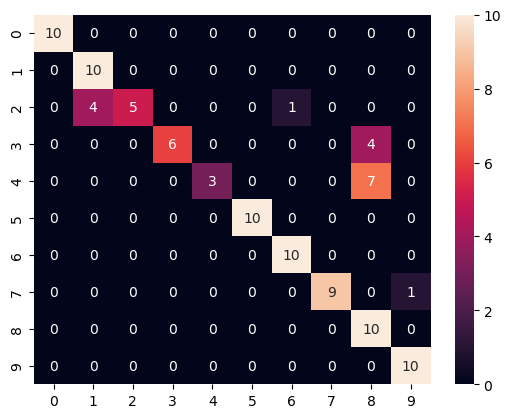

In [29]:
plot_confusion_matrix(y_true=dtw_y_test, y_pred=dtw_y_pred)

In [31]:
knn = KNN(n_neighbors=1, radius=1, distance_fun=fast_dtw)

dtw_accuracy_mean_d1, dtw_accuracy_std_d1, dtw_y_preds_d1, dtw_y_tests_d1 = user_independent_cross_validation(
	estimator=knn, 
	X=resample_dataset(X1), 
	y=y1
)

print("DOMAIN 01 - DYNAMIC TIME WARPING")

print("USER INDEPENDENT CROSS VALIDATION")
print(f"mean accuracy: {np.round(dtw_accuracy_mean_d1, 3)}")
print(f"std accuracy: {np.round(dtw_accuracy_std_d1, 3)}")

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1851/2988488513.py:68: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  prediction = mode(knn_labels, axis=1)[0]


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1851/2988488513.py:68: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  prediction = mode(knn_labels, axis=1)[0]


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1851/2988488513.py:68: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  prediction = mode(knn_labels, axis=1)[0]


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1851/2988488513.py:68: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  prediction = mode(knn_labels, axis=1)[0]


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1851/2988488513.py:68: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  prediction = mode(knn_labels, axis=1)[0]


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1851/2988488513.py:68: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  prediction = mode(knn_labels, axis=1)[0]


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1851/2988488513.py:68: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  prediction = mode(knn_labels, axis=1)[0]


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1851/2988488513.py:68: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  prediction = mode(knn_labels, axis=1)[0]


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1851/2988488513.py:68: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  prediction = mode(knn_labels, axis=1)[0]


  0%|          | 0/100 [00:00<?, ?it/s]

DOMAIN 01 - DYNAMIC TIME WARPING
USER INDEPENDENT CROSS VALIDATION
mean accuracy: 0.743
std accuracy: 0.146


/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_1851/2988488513.py:68: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  prediction = mode(knn_labels, axis=1)[0]


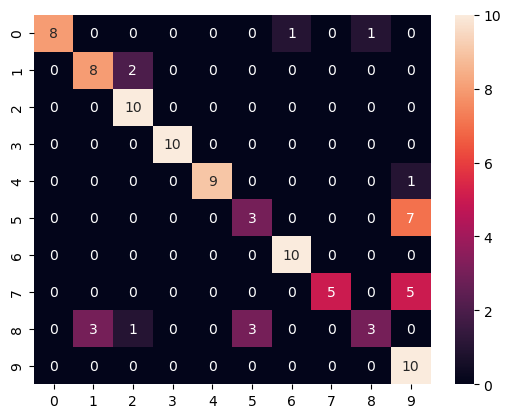

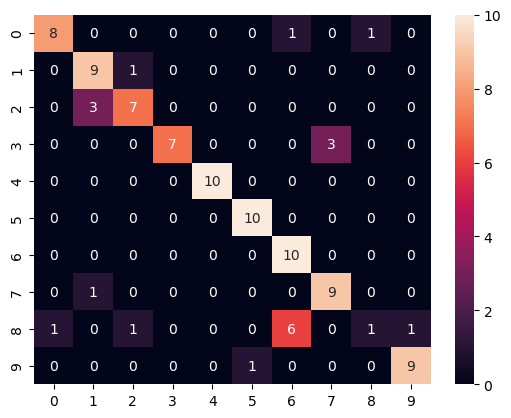

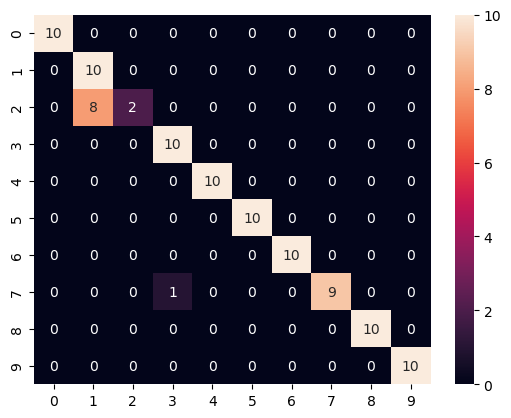

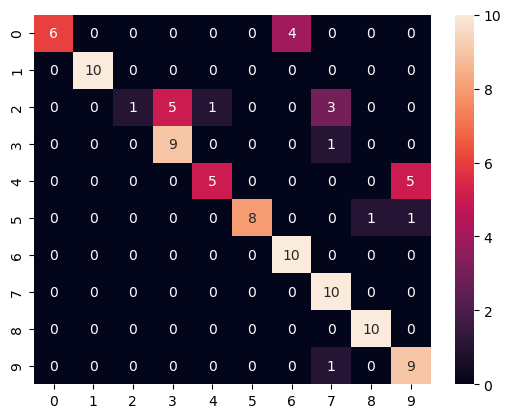

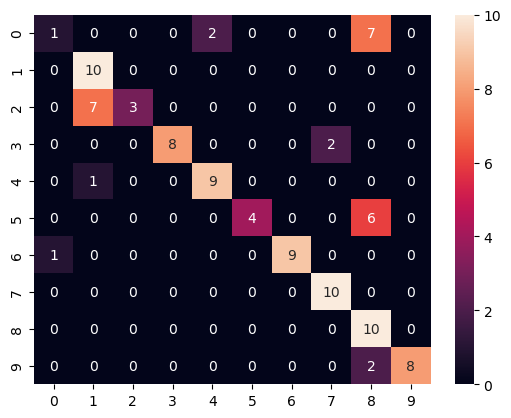

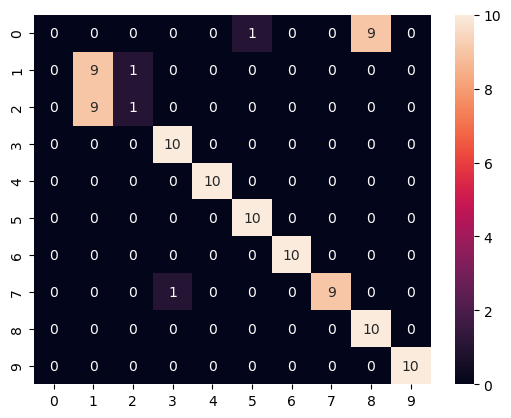

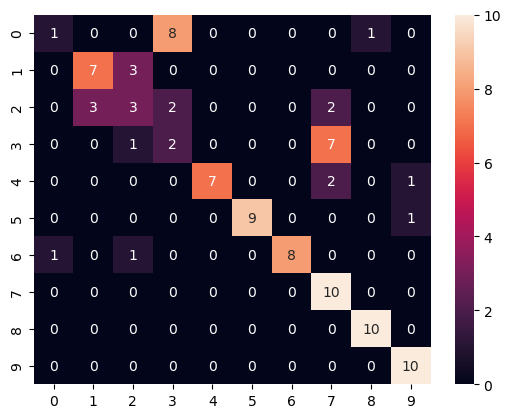

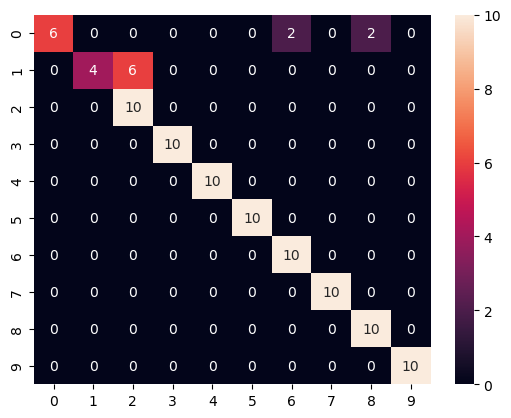

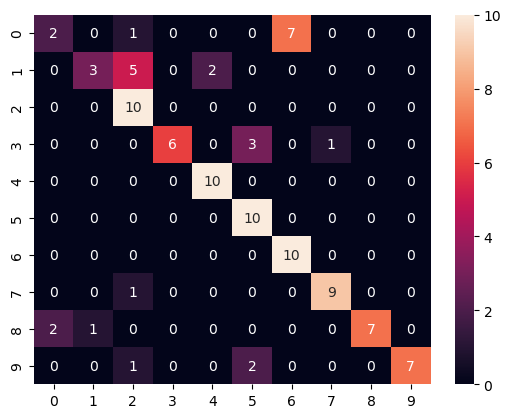

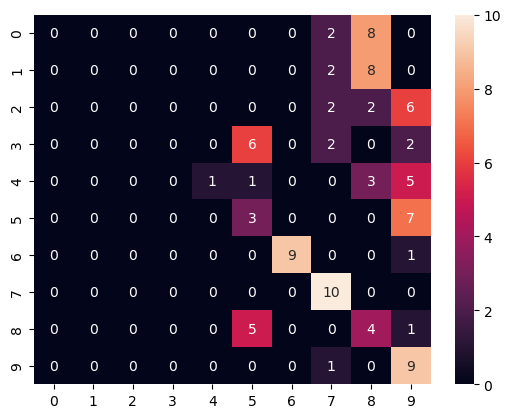

In [32]:
for (y_test_dtw, y_pred_dtw) in zip(dtw_y_tests_d1, dtw_y_preds_d1):
	plot_confusion_matrix(y_true=y_test_dtw, y_pred=y_pred_dtw)

In [38]:
knn_ = KNN(n_neighbors=1, radius=1, distance_fun=fast_dtw)

dtw_accuracy_mean_d1_, dtw_accuracy_std_d1_, dtw_y_preds_d1, dtw_y_tests_d1_ = user_dependent_cross_validation(
	estimator=knn_, 
	X=resample_dataset(X1), 
	y=y1
)

print("DOMAIN 01 - DYNAMIC TIME WARPING")

print("USER INDEPENDENT CROSS VALIDATION")
print(f"mean accuracy: {np.round(dtw_accuracy_mean_d1_, 3)}")
print(f"std accuracy: {np.round(dtw_accuracy_std_d1_, 3)}")

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3
 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

### $P Recognizer

In [23]:
class PointCloudRecognizer:
	def __init__(self, N = 64):
		self.N = N
		self.recognizer = None

	def fit(self, X: npt.NDArray, y: npt.NDArray):
		"""_summary_

		Parameters
		----------
		X : npt.NDArray, shape (n_samples, n_timepoints, vec_dimension)
			Training data
		y : npt.NDArray, shape (n_samples,)
			Training target values

		Returns
		-------
		_type_
			_description_
		"""
		self.X = X
		self.y = y

		training_data = []

		# for each vector of data points
		for (gesture, label) in zip(X, y):
			# we have 3D gesture data points 
			# $p-recognizer only accept 2D data points so we need to reduce to 2 dimensions
			pca = PCA(n_components=2)
			gesture_2d = pca.fit_transform(gesture)

			# convert each data points to point object
			points = []
			for (x1, x2) in gesture_2d:
				point = Point(x1, x2)
				points.append(point)
			
			training_data.append(Template(label, points))
		
		self.recognizer = Recognizer(training_data)
		return self.recognizer
			
	def predict(self, X: npt.NDArray):
		"""_summary_

		Parameters
		----------
		X : npt.NDArray, shape (n_samples, n_timepoints, vec_dimension)
			Testing data

		Returns
		-------
		_type_
			_description_
		"""
		if not self.recognizer:
			raise ValueError("You must fit the model first.") 

		results = []

		for gesture in tqdm(X):
			pca = PCA(n_components=2)
			gesture_2d = pca.fit_transform(gesture)

			points = []
			for (x1, x2) in gesture_2d:
				point = Point(x1, x2)
				points.append(point)

			result = self.recognizer.recognize(points)
			results.append(result[0])

		return results

In [26]:
recognizer = PointCloudRecognizer()

pcr_accuracy, pcr_y_pred, pcr_y_test = test_algo(
	estimator=recognizer,
	X=resample_dataset(X3), 
	y=y3
)

print("DOMAIN 01 - DYNAMIC TIME WARPING")

print("TEST ALGO")
print(f"accuracy: {np.round(pcr_accuracy, 3)}")

  0%|          | 0/100 [00:00<?, ?it/s]

DOMAIN 01 - DYNAMIC TIME WARPING
TEST ALGO
accuracy: 0.96


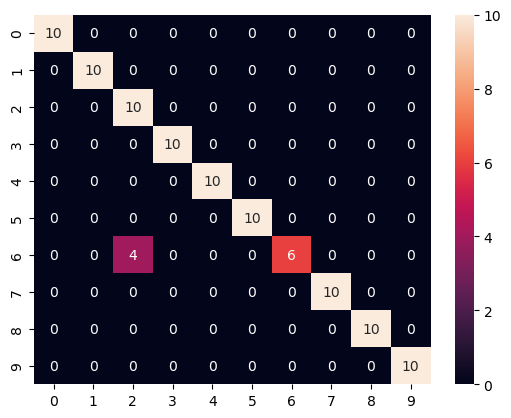

In [27]:
plot_confusion_matrix(y_true=pcr_y_test, y_pred=pcr_y_pred)

In [26]:
recognizer = PointCloudRecognizer()

X_scaled_and_resampled = standardize(X, N = 64)
pcr_accuracy_mean, pcr_accuracy_std, y_preds, y_tests = user_independent_cross_validation(estimator=recognizer, X=X_scaled_and_resampled, y=y)

print("DOMAIN 01 - $P Recognizer")

print("USER INDEPENDENT CROSS VALIDATION")
print(f"mean accuracy: {np.round(pcr_accuracy_mean, 3)}")
print(f"std accuracy: {np.round(pcr_accuracy_std, 3)}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Neural Network